# Controlador de vuelo para vehículos aéreos no tripulados multi-rotor basado en técnicas de aprendizaje profundo

## Entrenamiento Red LSTM

### Javier Cárdenas - Uriel Carrero

## 1. Descripción del Dataset

#### Importar Librerías

In [1]:
import os
import sys
import random
import csv

import matplotlib.pyplot as plt     # Gráficos
import pandas as pd
pd.set_option('display.max_columns', None) #Para mostrar todas las columnas

import numpy as np                  # Cómputo Numérico
seed = 5
np.random.seed(seed)
np.seterr(divide = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
import tensorflow as tf
print(tf.__version__)
assert (tf.__version__=='2.2.3'), 'Versión incorrecta de Tensorflow, por favor instale 2.2.3r'
#assert (tf.__version__=='2.4.1'), 'Versión incorrecta de Tensorflow, por favor instale 2.4.1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import keras as kr
from tensorflow.keras import models, layers

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

2.5.0


AssertionError: Versión incorrecta de Tensorflow, por favor instale 2.2.3r

In [1]:
gpus = tf.config.list_physical_devices('GPU')
config = ConfigProto()
if gpus:
    try:
        config.gpu_options.allow_growth = True
        tf.compat.v1.enable_eager_execution()

        os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
session = InteractiveSession(config=config)

NameError: name 'tf' is not defined

In [4]:
import gc #garbage collector
import gc; gc.enable()

## Cargar Datos

### Leemos el Dataset

In [5]:
root = '../logs/Datasets/'
dataset_name = 'DatasetXYZ_Matlab'
rootdir = root+dataset_name
ext_csv = True
if not os.path.exists(rootdir):
    print(f"{rootdir} not exist")
if ext_csv:
    # Colocar la extensión csv porque ajá
    for filename in os.listdir(rootdir):
        if not filename.endswith(".csv"):
            os.rename(f'{rootdir}/{filename}',f'{directory}/{filename+".csv"}')

In [6]:
df = pd.read_csv(os.path.join(rootdir, random.choice(os.listdir(rootdir))))
delete_list =['Time', 'Bat_V','Bat_Percentage','P_r', 'Q_r', 'R_r', 'Flag_Pitch_Roll','Ac_Dx', 'Ac_Dy', 'Ac_Dz','Sonar Altitud','Pressure Altitud', 'Acceleracion P', 'Acceleracion Q', 'Acceleracion R']+['Yaw_r', 'Pitch_r','Roll_r']
df_list = df.columns.to_list()
rpm_list = [i for i in df_list if ("Motor" in i)]
states_list = [i for i in df_list if not ((i in delete_list) or (i in rpm_list))]

In [7]:
df_desc = []
for filename in os.listdir(rootdir):
    if not filename.endswith(".csv"):
        continue
    df = pd.read_csv(os.path.join(rootdir, filename))
    df =  df.drop(delete_list, axis=1)
    df_desc.append(df)
df_desc = pd.concat(df_desc)
df_desc = df_desc.describe()

In [8]:
dataset = []
for filename in os.listdir(rootdir):
    if not filename.endswith(".csv"):
        continue
        
    df = pd.read_csv(os.path.join(rootdir, filename))
    df =  df.drop(delete_list, axis=1)
    x = df.drop(rpm_list, axis=1)
    y = df.drop(states_list, axis=1)
    dataset.append([x, y])

df = None
x = None
y= None

#### Descripton del dataset 

In [9]:
df_desc.to_csv('data_description.csv', index=False)
df_desc

,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,Motor1,Motor2,Motor3,Motor4,X_r,Y_r,Z_r,Dx_r,Dy_r,Dz_r,Gyro P,Gyro Q,Gyro R,Acceleracion X,Acceleracion Y,Acceleracion Z
count,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06,2.472712e+06
mean,9.833495e-03,-1.556140e-02,-1.542378e+00,-9.508851e-06,1.432449e-04,1.753021e-05,9.774424e-06,-1.245464e-04,-4.519551e-03,1.253656e-06,-1.777626e-06,1.018388e-05,2.364944e+02,-2.365144e+02,2.365036e+02,-2.365019e+02,9.762597e-03,-1.502060e-02,-1.533722e+00,7.279467e-06,-1.302214e-04,-1.351343e-02,-9.498748e-03,-7.501789e-03,1.510228e-03,-6.456851e-06,-4.945169e-05,-1.645668e-04
std,1.379407e-01,8.393116e-02,3.145502e-01,5.378968e-04,1.141644e-02,1.303408e-02,1.356381e-01,8.550414e-02,2.887440e-01,3.807025e-02,7.550894e-02,2.879643e-03,2.358383e+01,2.358397e+01,2.356496e+01,2.357689e+01,1.350825e-01,7.629898e-02,3.142020e-01,3.893195e-01,1.227141e-01,6.133520e+00,3.801734e-02,7.599522e-02,3.004052e-03,9.442529e-01,5.763878e-01,9.736049e-01
min,-1.391956e+00,-8.611585e-01,-3.318702e+00,-2.592636e-02,-1.766435e-01,-2.735551e-01,-3.435130e+00,-1.698784e+00,-4.524404e+00,-3.677774e+00,-2.278249e+00,-3.157852e-01,1.000000e+01,-4.613083e+02,1.000000e+01,-4.609848e+02,-1.230000e+00,-4.900000e-01,-2.774623e+00,-9.799999e+01,-7.400000e+01,-4.000000e+02,-3.682162e+00,-2.300421e+00,-3.116516e-01,-7.791275e+01,-1.226203e+02,-1.017578e+01
25%,-1.115418e-03,-3.061521e-03,-1.685227e+00,-1.774179e-05,-3.816560e-04,-3.025844e-04,-9.488551e-04,-3.165745e-03,-7.397021e-03,-1.921744e-03,-1.464281e-03,-9.217942e-04,2.356213e+02,-2.374752e+02,2.356235e+02,-2.374746e+02,0.000000e+00,0.000000e+00,-1.682275e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.141907e-02,-8.973711e-03,4.131773e-04,-1.010835e-02,-2.937366e-02,-1.166622e-01
50%,8.662618e-05,-6.380662e-04,-1.501099e+00,-1.657218e-07,1.142368e-04,9.260539e-06,-1.982498e-05,-6.900027e-06,3.641400e-04,1.972023e-06,-3.284808e-06,-2.365821e-06,2.365394e+02,-2.365381e+02,2.365418e+02,-2.365374e+02,0.000000e+00,0.000000e+00,-1.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.498030e-03,-7.503306e-03,1.504728e-03,0.000000e+00,0.000000e+00,-5.827053e-04
75%,1.281199e-03,1.094484e-03,-1.428414e+00,1.793741e-05,6.739650e-04,2.987884e-04,9.320468e-04,3.195953e-03,7.929627e-03,1.931848e-03,1.451934e-03,9.227290e-04,2.374221e+02,-2.355701e+02,2.374210e+02,-2.355679e+02,0.000000e+00,0.000000e+00,-1.410000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.570837e-03,-6.038715e-03,2.587983e-03,1.001506e-02,2.907393e-02,1.149229e-01
max,1.304069e+00,7.688133e-01,-4.311047e-02,2.609694e-02,1.636863e-01,2.819031e-01,3.232185e+00,1.410892e+00,3.718756e+00,3.680140e+00,3.494434e+00,1.693936e-01,4.609845e+02,-1.000000e+01,4.611932e+02,-1.000000e+01,1.120000e+00,2.200000e-01,0.000000e+00,9.600000e+01,8.600000e+01,3.807929e+02,3.665524e+00,3.509438e+00,1.732130e-01,1.157938e+02,1.021483e+02,1.456204e+01


Conteo de longitud de trayectorias

{20001: 44, 23201: 48, 42201: 10, 3001: 1, 4401: 1, 6201: 8}


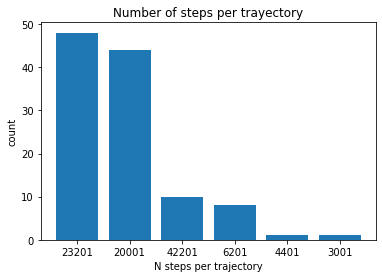

In [10]:
class Counter:
    def __init__(self):
        self.dict = {}
    def add(self, item):
        count = self.dict.get(item, 0)
        self.dict[item] = count + 1
        
    def counts(self, desc=None):
        result = [(val, key) for key, val in self.dict.items()]
        result.sort()
        if desc: result.reverse()
        print(self.dict)
        return result
    
    def mean(self):
        result = [val*key for key, val in self.dict.items()]
        return sum(result)/len(result)
    
    def total(self):
        result = [val*key for key, val in self.dict.items()]
        return sum(result)

c = Counter()
for data in dataset:
    x, _ = data
    c.add(len(x))
c_hist = c.counts(desc=True)

x = []
y = [] 
for i in c_hist:
    x.append(str(i[1]))
    y.append(i[0])

plt.bar(x, y, width = 0.8)
plt.title('Number of steps per trayectory')
plt.xlabel('N steps per trajectory')
plt.ylabel('count')
plt.show()

In [11]:
df = pd.read_csv(os.path.join(rootdir, random.choice(os.listdir(rootdir))))
Ts = df['Time'].to_list()[1]-df['Time'].to_list()[0]    # Sample Time
T = df['Time'].to_list()[-1]-df['Time'].to_list()[0]    # Signal Duration
N = c.mean()                                   # Average Number of Samples
df = None

In [12]:
print(f'Dataset Size: {( ( (sys.getsizeof(dataset[0][0])+sys.getsizeof(dataset[0][1])) *len(dataset)/1024) /1024)/1024} GB')
print(f'Dataset len: {len(dataset)} Signals')
print(f'Inputs len: {len(states_list)}, Inputs: {states_list}')
print(f'Outputs len: {len(rpm_list)}, Outputs: {rpm_list}')
print(f'Sample Time: {"{:.2f}".format(Ts*1000)} ms, Sample Freq: {"{:.2f}".format(1/Ts)} Hz')
print(f'Time Signal Duration: {"{:.2f}".format(T)}')
print(f'Number of Samples per Signal: {"{:.0f}".format(N)}')
print(f'Number of Samples: {"{:.0f}".format(c.total())}')

Dataset Size: 0.46735382080078125 GB
Dataset len: 112 Signals
Inputs len: 24, Inputs: ['X', 'Y', 'Z', 'Yaw', 'Roll', 'Pitch', 'Dx', 'Dy', 'Dz', 'P', 'Q', 'R', 'X_r', 'Y_r', 'Z_r', 'Dx_r', 'Dy_r', 'Dz_r', 'Gyro P', 'Gyro Q', 'Gyro R', 'Acceleracion X', 'Acceleracion Y', 'Acceleracion Z']
Outputs len: 4, Outputs: ['Motor1', 'Motor2', 'Motor3', 'Motor4']
Sample Time: 5.00 ms, Sample Freq: 200.00 Hz
Time Signal Duration: 116.00
Number of Samples per Signal: 412119
Number of Samples: 2472712


#### Normalización de Estados (Entradas) y Acciones (Salidas)

In [13]:
def Norm(df, df_desc):
    for prop in list(df.columns):
        try:
            df[prop] = (df[prop]-df_desc[prop]["mean"])/(df_desc[prop]["max"]-df_desc[prop]["min"])
        except:
            pass
    return df

In [14]:
for i, data in enumerate(dataset):
    x, y = data
    x = Norm(x, df_desc)
    y = Norm(y, df_desc)
    dataset[i]=[x,y]

In [15]:
data[0].describe()

,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,X_r,Y_r,Z_r,Dx_r,Dy_r,Dz_r,Gyro P,Gyro Q,Gyro R,Acceleracion X,Acceleracion Y,Acceleracion Z
count,23201.000000,23201.000000,23201.000000,23201.000000,23201.000000,23201.000000,23201.000000,23201.000000,23201.000000,23201.000000,2.320100e+04,23201.000000,23201.000000,23201.000000,23201.000000,2.320100e+04,2.320100e+04,23201.000000,23201.000000,2.320100e+04,23201.000000,2.320100e+04,2.320100e+04,23201.000000
mean,-0.051516,-0.253376,-0.002824,0.000126,0.000637,0.000361,-0.000075,-0.001366,0.000777,0.000001,4.048801e-07,-0.000002,-0.059545,-0.582903,-0.006331,-1.814909e-06,-2.558584e-05,0.000001,0.000001,4.048911e-07,-0.000002,1.142971e-08,3.021466e-07,0.000002
std,0.064054,0.064855,0.049058,0.006406,0.066672,0.036580,0.026347,0.052322,0.006690,0.007226,1.560565e-02,0.003478,0.069152,0.101191,0.057954,4.603488e-03,3.192057e-03,0.002654,0.007226,1.560565e-02,0.003902,4.800864e-03,1.759773e-03,0.011120
min,-0.207869,-0.466110,-0.099392,-0.089671,-0.324709,-0.294197,-0.239547,-0.307015,-0.051732,-0.049667,-1.332194e-01,-0.024796,-0.170112,-0.668985,-0.113990,-3.814434e-01,-4.624992e-01,-0.384207,-0.049667,-1.332194e-01,-0.025527,-4.591475e-02,-1.031939e-02,-0.130398
25%,-0.118775,-0.292251,-0.022731,-0.000228,-0.007331,-0.001146,-0.000598,-0.006895,-0.000141,-0.000930,-4.056385e-04,-0.001983,-0.144580,-0.668985,-0.031095,-3.752303e-08,8.138837e-07,0.000017,-0.000930,-4.056386e-04,-0.002343,-8.463226e-05,-2.738479e-04,-0.004475
50%,-0.018555,-0.279155,0.004182,0.000161,0.000602,0.000176,-0.000048,-0.000029,0.000705,0.000006,3.988835e-06,-0.000037,-0.021176,-0.668985,0.001341,-3.752303e-08,8.138837e-07,0.000017,0.000006,3.988811e-06,-0.000021,2.748056e-06,-8.536240e-08,0.000006
75%,-0.000622,-0.219058,0.031380,0.000555,0.009880,0.001939,0.000495,0.006511,0.001585,0.000948,4.432086e-04,0.001926,0.000101,-0.499971,0.033778,-3.752303e-08,8.138837e-07,0.000017,0.000948,4.432086e-04,0.002279,9.261619e-05,2.664274e-04,0.004520
max,0.088984,0.067888,0.063842,0.062096,0.378415,0.316189,0.268253,0.263818,0.047012,0.038967,1.476582e-01,0.032860,0.017122,0.021156,0.069819,4.123711e-01,8.138837e-07,0.056370,0.038967,1.476582e-01,0.032189,4.956677e-02,2.672328e-02,0.107661


In [16]:
data[1].describe()

,Motor1,Motor2,Motor3,Motor4
count,23201.000000,23201.000000,23201.000000,23201.000000
mean,0.000275,-0.000243,0.000265,-0.000258
std,0.011447,0.011446,0.011619,0.011703
min,-0.151179,-0.164330,-0.151051,-0.164727
25%,-0.001955,-0.002172,-0.001973,-0.002219
50%,0.000127,-0.000069,0.000095,-0.000092
75%,0.002110,0.002134,0.002092,0.002095
max,0.165055,0.150372,0.165294,0.150400


#### División del dataset para entrenamiento, validación, prueba

In [17]:
X = []
Y = []

for sample in dataset:
    x, y = sample
    X.append(x)
    Y.append(y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train,  X_val, Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.15)

del X
del Y

In [18]:
print(f'Total={len(dataset)}, Entrenamiento={len(X_train)} ({round(100*len(X_train)/len(dataset))}%),'\
      f'Validación={len(X_val)} ({round(100*len(X_val)/len(dataset))}%),'\
      f'Prueba={len(X_test)} ({round(100*len(X_test)/len(dataset))}%),')

Total=112, Entrenamiento=85 (76%),Validación=15 (13%),Prueba=12 (11%),


#### Generador de Ejemplos de entrenamiento

Entrenar un modelo con una señal de 50000 datos en cada iteración sería una tarea que tomaría demasiado tiempo, así mismo, cuando se necesite realizar la inferencia del modelo, se necesitaría esa misma cantidad de datos, por lo que no se utiliza toda la señal de entrenamiento, sino pequeños segmentos de tamaño N, por lo que se generarán M-N (longitud de toda la señal, 50000) señales de longitud N para el entrenamiento, lo que aumentaría el consumo de memoria. Por tal motivo se define un generador.

In [19]:
class DataGenerator:
    def __init__(self, X=[], Y=[], dataset = None, batch_size=512, window=512, sequence_out=False, variable_window=False, delta_window=1):
        if dataset:
            for data in dataset:
                X.append(data[0])
                Y.append(data[1])
            self.X = X
            self.Y = Y
        elif X and Y:
            if len(X)!=len(Y):
                raise Exception("La longitud de datos de X e Y deben ser iguales")
            self.X = X
            self.Y = Y
        else:
            raise Exception("Debe especificar dataset o X, Y")
            
        self.n  = len(X)                 ### Número de ejemplos de entrenamiento
        x_shape = X[0].shape
        y_shape = Y[0].shape
        self.i  = x_shape[1]             ### Número de características
        self.j  = y_shape[1]             ### Número de salidas
        self.batch_size = batch_size
        self.window = window
        self.variable_window = variable_window
        self.delta_window = delta_window
        if self.variable_window:
            self.window_max = self.window+self.delta_window
            self.window_min = self.window-self.delta_window
            if self.window_min<1:
                raise IndexError(f'delta_window no puede ser igual o mayor a la ventana')
        self.sequence_out = sequence_out
        self.set_sequence()
        
    def set_sequence(self):
        if self.sequence_out:
            self.shapes = ((self.batch_size, self.window, self.i),
                           (self.batch_size, self.window, self.j))
        else:
            self.shapes = ((self.batch_size, self.window, self.i),
                           (self.batch_size, self.j))

    def buid_init(self):
        if self.variable_window:
            self.window = np.random.randint(self.window_min, self.window_max)
            self.set_sequence()
        self.samples = np.empty(shape= self.shapes[0], dtype='float32') 
        self.labels  = np.empty(shape= self.shapes[1], dtype='float32') 
        self.batchcount = 0
        
    def build_data(self):
        self.buid_init()
        while True:
            try:
                index = np.random.randint(0, self.n-1)            ### Trayectoria a seleccionar
                m = len(self.X[index])          ### Número de steps por ejemplo
                if m-self.window-1<=0:
                    raise IndexError(f'El tamaño de la ventana es mayor a la trayectoria')
                else:
                    start_index = np.random.randint(0, int(m-self.window-1))
                    final_index = start_index+self.window
                    self.samples[self.batchcount] = self.X[index][start_index:final_index].to_numpy()
                    if self.sequence_out:
                        self.labels[self.batchcount] = self.Y[index][start_index:final_index].to_numpy()
                    else:
                        self.labels[self.batchcount] = self.Y[index].loc[final_index]
            except IndexError as e:
                print(f'ERROR: Ejemplo {self.batchcount}: {e}')
                raise e
                
            self.batchcount += 1
            if self.batchcount >= self.batch_size:
                yield self.samples.astype(np.float32), self.labels.astype(np.float32)
                self.buid_init()

In [20]:
window = 64                    ### Número de steps por ejemplo
batch_size = 128               ### Número de ejemplos por batch
sequence_out = False
variable_window=True
delta_window=window/2

In [21]:
train_generator = DataGenerator(X=X_train, Y=Y_train, batch_size=batch_size, window=window, sequence_out=sequence_out, variable_window=variable_window, delta_window=delta_window)
val_generator   = DataGenerator(X=X_val,   Y=Y_val,   batch_size=batch_size, window=window, sequence_out=sequence_out, variable_window=variable_window, delta_window=delta_window)
test_generator  = DataGenerator(X=X_test,  Y=Y_test,  batch_size=batch_size, window=window, sequence_out=sequence_out, variable_window=variable_window, delta_window=delta_window)

In [22]:
dataset_train = tf.data.Dataset.from_generator(train_generator.build_data,
                                        output_types = (tf.float32, tf.float32))
dataset_val = tf.data.Dataset.from_generator(val_generator.build_data,
                                        output_types = (tf.float32, tf.float32))
dataset_test = tf.data.Dataset.from_generator(test_generator.build_data,
                                        output_types = (tf.float32, tf.float32))

In [23]:
for _ in range(5):
    x, y = next(train_generator.build_data())
    print(f'x.shape={x.shape}, y.shape={y.shape}')

x.shape=(128, 43, 24), y.shape=(128, 4)
x.shape=(128, 63, 24), y.shape=(128, 4)
x.shape=(128, 56, 24), y.shape=(128, 4)
x.shape=(128, 88, 24), y.shape=(128, 4)
x.shape=(128, 67, 24), y.shape=(128, 4)


## Keras Model

## Callbacks

In [24]:
main_metric = 'mean_squared_error'
#metrics = [main_metric, 'cosine_similarity', 'logcosh']
metrics = main_metric

#### Early Stopping

In [25]:
Early_Stopping = tf.keras.callbacks.EarlyStopping(monitor=f'val_{main_metric}', min_delta=0, patience=15, verbose=0, mode='auto')

#### Plotting

In [26]:
class PlotLosses(tf.keras.callbacks.Callback):
    def __init__(self, loss, figsize=(10,10)):
        self.loss = loss
        self.figsize = figsize
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.logs = []
        self.fig = plt.figure(figsize=self.figsize)
        if type(self.loss)==list:
            self.N = len(self.loss)
            for i in range(self.N):
                self.losses.append([])
                self.val_losses.append([])
        else:
            self.N = 1
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i+1)
        if self.N>1:
            for i, l in enumerate(self.loss):
                self.losses[i].append(logs.get(f'{l}'))
                self.val_losses[i].append(logs.get(f'val_{l}'))
        else:
            self.losses.append(logs.get(f'{self.loss}'))
            self.val_losses.append(logs.get(f'val_{self.loss}'))
        self.i += 1
        
        clear_output(wait=True)
        if self.N>1:
            self.fig, self.axs = plt.subplots(self.N, sharex=True, figsize=self.figsize)
            for i, l in enumerate(self.loss):
                self.axs[i].plot(self.x, self.losses[i], label=f"Train")
                self.axs[i].plot(self.x, self.val_losses[i], label=f"Validation")
                self.axs[i].set_title(f'{l}')
                self.axs[i].set_yscale('log')
                self.axs[i].grid()
                self.axs[i].legend()
            self.axs[i].set_xlabel('Epochs')
        else:
            plt.plot(self.x, self.losses, label=f"Train")
            plt.plot(self.x, self.val_losses, label=f"Validation")
            plt.suptitle(f'{self.loss}')
            plt.yscale('log')
            plt.xlabel('Epochs')
            plt.grid()
            plt.legend()
        plt.show()

#### Checkpoints

In [27]:
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=f'val_{main_metric}',
    mode='max',
    save_best_only=True)

In [28]:
plot_losses = PlotLosses(loss=metrics)
callbacks = [model_checkpoint_callback, Early_Stopping, plot_losses]

#### Definición del Modelo

In [35]:
model = models.Sequential()
model.add(layers.LSTM(128, input_shape=(None, len(states_list)), return_sequences=True))
model.add(kr.layers.convolutional.Conv1D(filters=128, kernel_size=7, padding='same', activation='relu'))
model.add(layers.LSTM(64, return_sequences=True))
model.add(kr.layers.convolutional.Conv1D(filters=64, kernel_size=7, padding='same', activation='relu'))
model.add(layers.LSTM(32))
#model.add(layers.LSTM(shapes[1][1]))#, return_sequences=True))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(len(rpm_list)))

#### Compilado el Modelo

In [36]:
opt = tf.keras.optimizers.Adam()
model.compile(loss=main_metric, optimizer=opt, metrics=metrics)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 128)         78336     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

#### Entrenamiento del Modelo

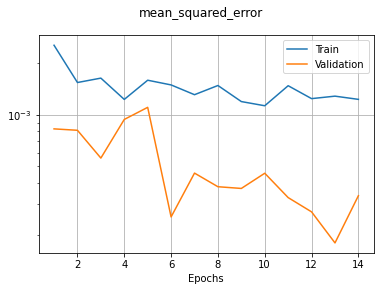

Epoch 15/120
54/85 [==================>...........] - ETA: 3s - loss: 0.0010 - mean_squared_error: 0.0010      

KeyboardInterrupt: 

In [37]:
%%time
EPOCHS = 120
#se usa el repeat para llamar al generador mas de una vez
#steps_per_epoch  = numero de batches de los datos para determinar una epoca terminada 
#Por defecto -> number of samples in your dataset divided by the batch size (LEN_DT//BATCH_SIZE_TRAIN)
#verbose = mostrar el avance del entrenamiento
#validation_steps = numero de batches de datos para validar en cada epoca
#workers?
#max_queue_size?
history = model.fit(dataset_train.repeat(), 
                    epochs=EPOCHS, 
                    steps_per_epoch = len(X_train),
                    callbacks=callbacks, 
                    verbose=1,
                    validation_data = dataset_val.repeat(),
                    validation_steps= len(X_val))

#### Se guarda el Modelo

In [52]:
I = 0
model.save(f'Modelos/{dataset_name}_{I}.h5')

### Evaluación del Modelo

#### Se carga el modelo

In [53]:
model = tf.keras.models.load_model(f'Modelos/{dataset_name}_{I}.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 128)         78336     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

#### Evaluación con dataset de prueba

In [54]:
%%time
n_batches = np.ceil((len(X_test)*len(X_test[0])/N)/batch_size)
losses = model.evaluate(dataset_test, steps = n_batches)
K = df_desc[rpm_list[0]]["max"]-df_desc[rpm_list[0]]["min"] #Ganancia del actuador
print(f'K={"{:.2f}".format(K)}')
if not type(metrics) == list:
    metrics = [metrics]
for i, l in enumerate(['loss']+metrics):
    print(f'{l}: {"{:.2e}".format(losses[i])} -> {"{:.2e}".format(losses[i]*K)} RPM')

1/1 [==============================] - 1s 1s/step - loss: 1.0294e-05 - mean_squared_error: 1.0294e-05
K=450.9845276
loss: 1.03e-05 -> 4.64e-03 RPM
mean_squared_error: 1.03e-05 -> 4.64e-03 RPM
Wall time: 1.15 s


#### Evaluación con 1 trayectoria

In [55]:
window_test = 3000
test_traj_generator  = DataGenerator(X=X_test,  Y=Y_test,  batch_size=1, window=window_test, sequence_out=True)

In [56]:
%%time
X, Y = next(test_traj_generator.build_data())
x = X[0]
y = Y[0]
y_pred = []
for i in range(0, len(x)):
    if i == 0:
        x_temp = x[0].reshape(1,  1, X.shape[2])
    elif i<=window:
        x_temp = x[0:i].reshape(1,  i, X.shape[2])
    else:
        x_temp = x[i-window:i].reshape(1,  window, X.shape[2])
    y_temp = model.predict(x_temp)
    y_pred.append(y_temp)
y_pred = np.array(y_pred).reshape(y.shape)

Wall time: 2min 39s


#### Visualización con 1 trayectoria

In [57]:
t = np.arange(0, len(y)*Ts, Ts)

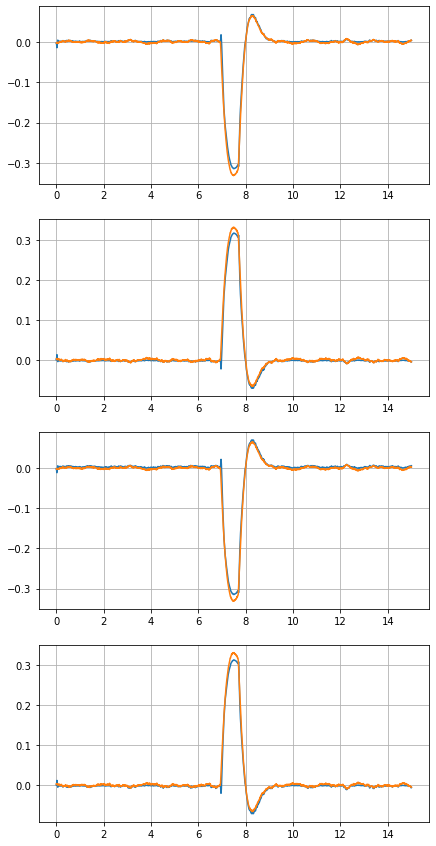

In [58]:
fig, axs = plt.subplots(Y.shape[2], figsize = (7,15))
for i in range(Y.shape[2]):
    axs[i].plot(t, y_pred[:,i], t, y[:,i])
    axs[i].grid()

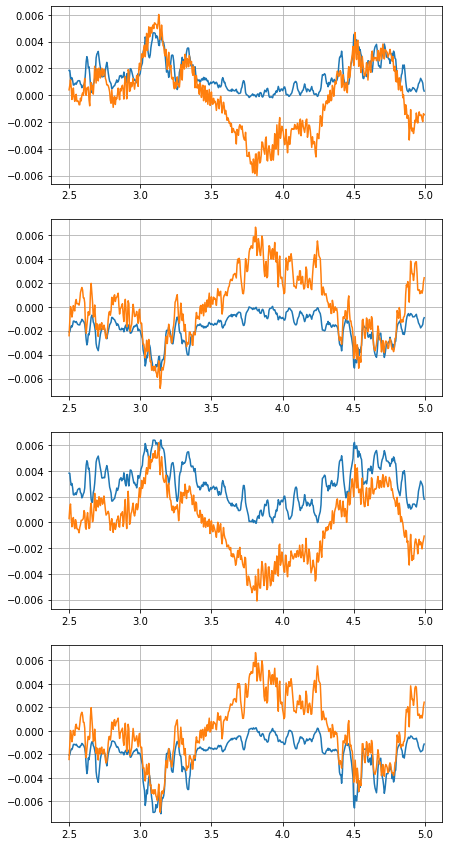

In [59]:
fig, axs = plt.subplots(Y.shape[2], figsize = (7,15))
for i in range(Y.shape[2]):
    axs[i].plot(t[500:1000], y_pred[500:1000,i], t[500:1000], y[500:1000,i])
    axs[i].grid()

#### Tiempo de inferencia tamaño entrada

In [60]:
import time

def MSE(y, y_pred):
    return (y-y_pred)**2

window_test = 1000
test_traj_batch = 100
test_traj_generator  = DataGenerator(X=X_test,  Y=Y_test,  batch_size=test_traj_batch, window=window_test, sequence_out=True)

window_len = []
inf_time = []
loss = []

x, y = next(test_traj_generator.build_data())

In [61]:
%%time
accum_time = 0
n_iter = 100
test_range = list(set(np.rint(np.logspace(0, np.log10(x.shape[1]-1), num=n_iter, endpoint=True))))
test_range.sort()
n_iter = len(test_range)
for k, i in enumerate(list(map(int,test_range))):
    inf_time_aux = []    # Tiempo de inferencia auxiliar
    loss_aux = []    # Costo Auxiliar
    init_time = time.time()
    for j in range(len(x)):
        x_5 = x[j][0:i].reshape(1,  i, x.shape[2])
        start_time = time.time()
        y_pred = model.predict(x_5)
        finish_time = time.time() - start_time
        inf_time_aux.append(finish_time)
        loss_aux.append(
            np.mean(
                MSE(y[j][i], y_pred)
            )
        )
    
    window_len.append(i)
    inf_time.append(np.mean(inf_time_aux))
    loss.append(np.mean(loss_aux))
    clear_output(wait=True)
    accum_time += time.time()-init_time
    print(f'iter = {k} de {test_range}, i = {i}, execution time = {"{:.2f}".format(np.max(accum_time))}s')

iter= 74 de 100, i= 999, execution time= 410.39s
Wall time: 6min 50s


In [62]:
inf_time_norm = np.array(inf_time)/max(inf_time)
loss_norm = np.array(loss)/max(loss)
performance = 1/(np.array(loss)*np.array(inf_time))
performance = np.array(performance)/max(performance)

Best window inference time=1 steps, time=39.84 ms
Best window MSE loss=60 steps, MSE=5.43e-06
Best window Performance (MSExTime)=59 steps, Value=1.55e-01


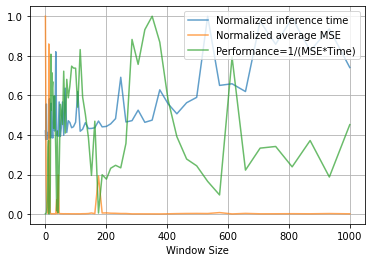

In [63]:
plt.figure()
plt.plot(window_len, inf_time_norm, label='Normalized inference time', alpha=0.7)
plt.plot(window_len, loss_norm, label='Normalized average MSE', alpha=0.7)
plt.plot(window_len, performance, label='Performance=1/(MSE*Time)', alpha=0.7)
plt.xlabel("Window Size")
plt.legend(loc=1)
plt.grid()

print(f'Best window inference time={np.argmin(inf_time_norm)} steps, time={"{:.2f}".format(np.min(inf_time)*1000)} ms')
print(f'Best window MSE loss={np.argmin(loss_norm)} steps, MSE={"{:.2e}".format(np.min(loss))}')
print(f'Best window Performance (MSExTime)={np.argmax(performance)} steps, Value={"{:.2e}".format(np.max(loss)/np.min(inf_time))}')

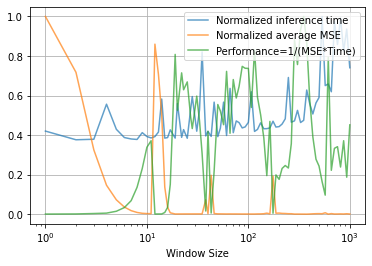

In [64]:
plt.figure()
plt.semilogx(window_len, inf_time_norm, label='Normalized inference time', alpha=0.7)
plt.semilogx(window_len, loss_norm, label='Normalized average MSE', alpha=0.7)
plt.semilogx(window_len, performance, label='Performance=1/(MSE*Time)', alpha=0.7)
plt.xlabel("Window Size")
plt.legend(loc=1)
plt.grid()